In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gtsrb-german-traffic-sign/Meta.csv
/kaggle/input/gtsrb-german-traffic-sign/Train.csv
/kaggle/input/gtsrb-german-traffic-sign/Test.csv
/kaggle/input/gtsrb-german-traffic-sign/Meta/37.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/35.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/11.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/31.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/4.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/40.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/33.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/9.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/.~lock.ClassesInformation.ods#
/kaggle/input/gtsrb-german-traffic-sign/Meta/14.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/1.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/39.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/20.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/38.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/2.png
/kaggle/input/gtsrb-german-traffic-sign/Meta/10.png


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

2025-09-21 06:02:52.139927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758434572.501041      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758434572.609232      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [37]:
train_dir = "/kaggle/input/gtsrb-german-traffic-sign/Train"
test_dir  = "/kaggle/input/gtsrb-german-traffic-sign/Test"

img_size   = (128,128)   # for transfer learning
#img_size=(48,48)  #for CNN
batch_size = 32
seed       = 42        # ensure reproducibility of the split

# 2. Split Train -> train/validation

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.2,   # 20% goes to validation
    subset="training",
    seed=seed
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed
)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [38]:
import tensorflow as tf
from tensorflow.keras import layers

# Random transforms that make sense for traffic signs
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),          
    layers.RandomTranslation(0.05, 0.05),    
    layers.RandomZoom(0.1),               
    layers.RandomContrast(0.1)  
])


normalizer = layers.Rescaling(1./255)

In [39]:
# Apply augmentation ONLY to training data
train_ds = train_ds.map(lambda x, y: (normalizer(data_augmentation(x, training=True)), y))
val_ds   = val_ds.map(lambda x, y: (normalizer(x), y))

# Improve pipeline performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
import os
class_folders = sorted(os.listdir(train_dir))   # all class sub-folders
print("Total number of classes:", len(class_folders))
for cls in sorted(os.listdir(train_dir)):
    n = len(os.listdir(os.path.join(train_dir, cls)))
    print(f"{cls}: {n}")

Total number of classes: 43
0: 210
1: 2220
10: 2010
11: 1320
12: 2100
13: 2160
14: 780
15: 630
16: 420
17: 1110
18: 1200
19: 210
2: 2250
20: 360
21: 330
22: 390
23: 510
24: 270
25: 1500
26: 600
27: 240
28: 540
29: 270
3: 1410
30: 450
31: 780
32: 240
33: 689
34: 420
35: 1200
36: 390
37: 210
38: 2070
39: 300
4: 1980
40: 360
41: 240
42: 240
5: 1860
6: 420
7: 1440
8: 1410
9: 1470


In [10]:
class_folders = sorted(os.listdir(train_dir))
counts = []
for cls in class_folders:
    n = len(os.listdir(os.path.join(train_dir, cls)))
    counts.append(n)

print("Counts per class:", counts)

Counts per class: [210, 2220, 2010, 1320, 2100, 2160, 780, 630, 420, 1110, 1200, 210, 2250, 360, 330, 390, 510, 270, 1500, 600, 240, 540, 270, 1410, 450, 780, 240, 689, 420, 1200, 390, 210, 2070, 300, 1980, 360, 240, 240, 1860, 420, 1440, 1410, 1470]


In [11]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.arange(len(counts)) 

class_weights_arr = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=np.repeat(classes, counts)  
)

# convert to dict for model.fit()
class_weights = dict(zip(classes, class_weights_arr))
print(class_weights)

{0: 4.342081949058693, 1: 0.41073748166771423, 2: 0.45365035288672917, 3: 0.6907857646229739, 4: 0.4342081949058693, 5: 0.4221468561584841, 6: 1.1690220632081096, 7: 1.447360649686231, 8: 2.1710409745293466, 9: 0.8214749633354285, 10: 0.7598643410852713, 11: 4.342081949058693, 12: 0.4052609819121447, 13: 2.5328811369509046, 14: 2.7631430584918957, 15: 2.3380441264162193, 16: 1.7879160966712266, 17: 3.3771748492678726, 18: 0.6078914728682171, 19: 1.5197286821705427, 20: 3.7993217054263564, 21: 1.6885874246339363, 22: 3.3771748492678726, 23: 0.6466930562427841, 24: 2.0263049095607237, 25: 1.1690220632081096, 26: 3.7993217054263564, 27: 1.3234212036318223, 28: 2.1710409745293466, 29: 0.7598643410852713, 30: 2.3380441264162193, 31: 4.342081949058693, 32: 0.44050106729580946, 33: 3.0394573643410854, 34: 0.46052384308198263, 35: 2.5328811369509046, 36: 3.7993217054263564, 37: 3.7993217054263564, 38: 0.49023505876469115, 39: 2.1710409745293466, 40: 0.6332202842377261, 41: 0.6466930562427841, 

In [12]:
num_classes=len(class_folders)

In [13]:
print(num_classes)

43


In [26]:
#BUILDING CNN FROM SCRATCH-METHOD 1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

model = Sequential([

    # Conv Block 1
    
    Input(shape=img_size + (3,)),
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.2),


    # Conv Block 2
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Conv Block 3
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),


    # Flatten + Dense Layers
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')

])

In [27]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 658,667 (2.51 MB)

 Trainable params: 657,451 (2.51 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [28]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(1e-3),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [29]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,CSVLogger
callbacks=[
    EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.2,min_lr=1e-6),
    ModelCheckpoint(filepath='model_check.h5',monitor='val_loss',save_best_only=True,save_weights_only=False,verbose=1),
    CSVLogger('cnn_training_log.csv', append=False)
]

In [30]:
history= model.fit(train_ds,validation_data=val_ds,epochs=15,callbacks=callbacks)

Epoch 1/15


I0000 00:00:1758435037.971488     103 service.cc:148] XLA service 0x7f10bc0051c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758435037.977666     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758435037.977694     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758435038.799371     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


  6/981 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - accuracy: 0.0292 - loss: 4.5815     

I0000 00:00:1758435046.590752     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.3305 - loss: 2.5417
Epoch 1: val_loss improved from inf to 0.61628, saving model to model_check.h5
981/981 ━━━━━━━━━━━━━━━━━━━━ 128s 116ms/step - accuracy: 0.3307 - loss: 2.5409 - val_accuracy: 0.8151 - val_loss: 0.6163 - learning_rate: 0.0010
Epoch 2/15
979/981 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7374 - loss: 0.8096
Epoch 2: val_loss improved from 0.61628 to 0.22015, saving model to model_check.h5
981/981 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7375 - loss: 0.8093 - val_accuracy: 0.9302 - val_loss: 0.2202 - learning_rate: 0.0010
Epoch 3/15
970/981 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8340 - loss: 0.5076
Epoch 3: val_loss improved from 0.22015 to 0.13533, saving model to model_check.h5
981/981 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8341 - loss: 0.5073 - val_accuracy: 0.9597 - val_loss: 0.1353 - learning_rate: 0.0010
Epoch 4/15
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8741 - loss: 0

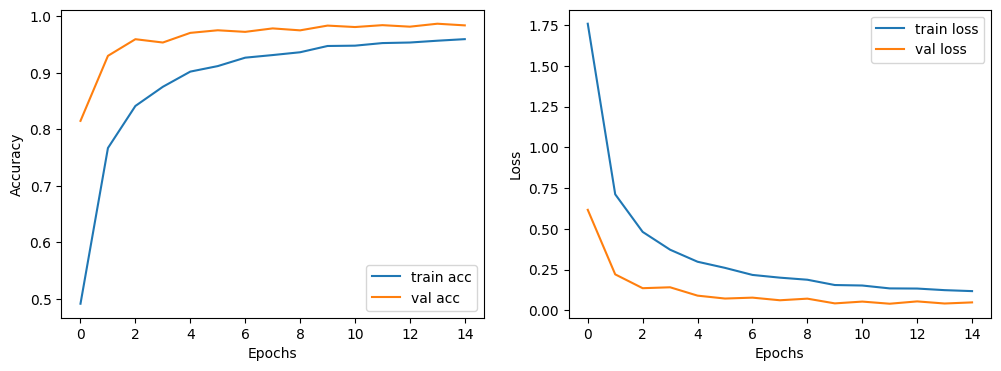

In [31]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


In [32]:
# GTSRB: class-id -> human readable label
gtsrb_labels = {
     0: "Speed limit (20km/h)",
     1: "Speed limit (30km/h)",
     2: "Speed limit (50km/h)",
     3: "Speed limit (60km/h)",
     4: "Speed limit (70km/h)",
     5: "Speed limit (80km/h)",
     6: "End of speed limit (80km/h)",
     7: "Speed limit (100km/h)",
     8: "Speed limit (120km/h)",
     9: "No passing",
    10: "No passing for vehicles over 3.5 metric tons",
    11: "Right-of-way at the next intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "Vehicles over 3.5 metric tons prohibited",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve to the left",
    20: "Dangerous curve to the right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End of all speed and passing limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout mandatory",
    41: "End of no passing",
    42: "End of no passing by vehicles over 3.5 metric tons"
}


In [33]:
import tensorflow as tf

tmp_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,        
    image_size=(48,48),  
    batch_size=1         
)
class_names = tmp_ds.class_names
print("Total classes:", len(class_names))
print("Class names:", class_names)


Found 39209 files belonging to 43 classes.
Total classes: 43
Class names: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


In [34]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array

def predict_image(model, img_path, class_names, img_size=(48,48)):
    
    img = load_img(img_path,target_size=img_size)
    img_array = img_to_array(img) / 255.0     
    img_array = np.expand_dims(img_array, 0)   

    probs = model.predict(img_array)
    class_idx = np.argmax(probs[0])

    predicted_label = class_names[class_idx]
    human_label  = gtsrb_labels[class_idx]
    confidence = probs[0][class_idx]
    plt.imshow(load_img(img_path))
    plt.show()

    return predicted_label,human_label,confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step


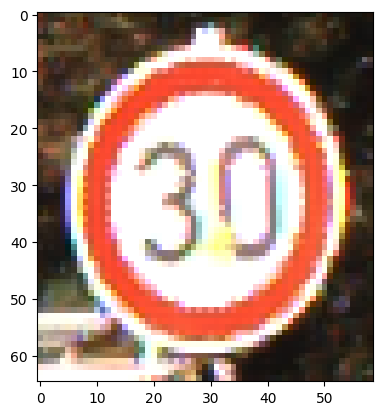

Predicted Class: 1,Label:Speed limit (30km/h),confidence: 99.99%)


In [35]:
predicted_label,human_label,confidence = predict_image(model,
                            "//kaggle/input/gtsrb-german-traffic-sign/Test/00024.png",
                            class_names)

print(f"Predicted Class: {predicted_label},Label:{human_label},confidence: {confidence:.2%})")

In [36]:
model.save("/kaggle/working/gtsrb_cnn.h5")

In [40]:
#BY TRANSFER LEARNING
from tensorflow.keras.applications import ResNet50,EfficientNetB0,MobileNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
#BY MOBILE NET
base_model=MobileNetV2(weights='imagenet',include_top=False,input_shape=(128,128,3))
base_model.trainable=False
x=GlobalAveragePooling2D()(base_model.output)
x=Dense(256, activation='relu')(x)
x=BatchNormalization()(x)
x=Dropout(0.4)(x)
x=Dense(128,activation='relu')(x)
x=BatchNormalization()(x)
x=Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)  # 43 classes

model = Model(inputs=base_model.input, outputs=output)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [41]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,625,899 (10.02 MB)

 Trainable params: 367,147 (1.40 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

In [42]:
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
callbacks=[
    EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.2,min_lr=1e-6),
]

In [44]:
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=7,
    callbacks=callbacks,
    class_weight=class_weights

)

Epoch 1/7
981/981 ━━━━━━━━━━━━━━━━━━━━ 189s 178ms/step - accuracy: 0.3361 - loss: 2.4204 - val_accuracy: 0.6829 - val_loss: 0.9680 - learning_rate: 0.0010
Epoch 2/7
981/981 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.6007 - loss: 1.1255 - val_accuracy: 0.7438 - val_loss: 0.7533 - learning_rate: 0.0010
Epoch 3/7
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.6670 - loss: 0.8842 - val_accuracy: 0.7744 - val_loss: 0.6652 - learning_rate: 0.0010
Epoch 4/7
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.7021 - loss: 0.7743 - val_accuracy: 0.7920 - val_loss: 0.6172 - learning_rate: 0.0010
Epoch 5/7
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.7305 - loss: 0.6788 - val_accuracy: 0.8031 - val_loss: 0.5677 - learning_rate: 0.0010
Epoch 6/7
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.7440 - loss: 0.6315 - val_accuracy: 0.8179 - val_loss: 0.5402 - learning_rate: 0.0010
Epoch 7/7
981/981 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.7559 - loss: 

In [68]:
callbacks=[
    EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.2,min_lr=1e-6),
    ModelCheckpoint(filepath='mobilenet_model_check.h5',monitor='val_loss',save_best_only=True,save_weights_only=False,verbose=1),
    CSVLogger('mobilenet_training_log.csv', append=False)
]

In [63]:
#6. Fine-Tune Last Layers
# -------------------------------
for layer in base_model.layers[-40:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_fine1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5693 - loss: 1.3012
Epoch 1: val_loss improved from inf to 0.88757, saving model to mobilenet_model_check.h5
981/981 ━━━━━━━━━━━━━━━━━━━━ 55s 32ms/step - accuracy: 0.5693 - loss: 1.3011 - val_accuracy: 0.7115 - val_loss: 0.8876 - learning_rate: 1.0000e-05
Epoch 2/15
978/981 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6581 - loss: 0.8801
Epoch 2: val_loss improved from 0.88757 to 0.70544, saving model to mobilenet_model_check.h5
981/981 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.6581 - loss: 0.8800 - val_accuracy: 0.7624 - val_loss: 0.7054 - learning_rate: 1.0000e-05
Epoch 3/15
978/981 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7042 - loss: 0.6974
Epoch 3: val_loss improved from 0.70544 to 0.60941, saving model to mobilenet_model_check.h5
981/981 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.7043 - loss: 0.6974 - val_accuracy: 0.7911 - val_loss: 0.6094 - learning_rate: 1.0000e-05
Epoch 4/15
980/981 ━━━━

In [70]:
history_fine1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    initial_epoch=15,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 16/25
979/981 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9549 - loss: 0.0991
Epoch 16: val_loss improved from inf to 0.19386, saving model to mobilenet_model_check.h5
981/981 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9549 - loss: 0.0991 - val_accuracy: 0.9366 - val_loss: 0.1939 - learning_rate: 1.0000e-05
Epoch 17/25
980/981 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9625 - loss: 0.0888
Epoch 17: val_loss improved from 0.19386 to 0.18777, saving model to mobilenet_model_check.h5
981/981 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.9625 - loss: 0.0888 - val_accuracy: 0.9381 - val_loss: 0.1878 - learning_rate: 1.0000e-05
Epoch 18/25
978/981 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9693 - loss: 0.0788
Epoch 18: val_loss did not improve from 0.18777
981/981 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.9693 - loss: 0.0788 - val_accuracy: 0.9404 - val_loss: 0.1893 - learning_rate: 1.0000e-05
Epoch 19/25
978/981 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accurac

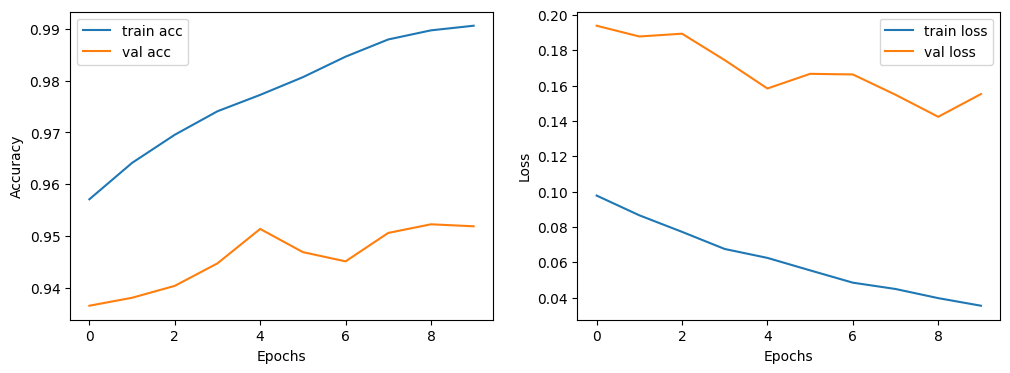

In [71]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history_fine1.history['accuracy'], label='train acc')
plt.plot(history_fine1.history['val_accuracy'], label='val acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_fine1.history['loss'], label='train loss')
plt.plot(history_fine1.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [72]:
model.save("/kaggle/working/gtsrb_mobilenet.h5")